# WATER BAG PREDICTION PER CRITICAL REGION

### BASED ON INMET METHEOROLOGICAL STATIONS DATA

---
#### Import modules and libraries

In [14]:
import os, json, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

## Load & Preprocess Data

#### Water bag groupped events collection

In [15]:
waterbags = pd.read_csv('../Dados/Catalog/water_bag_catalog_google.csv', index_col=0)
clusters = pd.read_csv('../Dados/Catalog/water_bag_clusters.csv', index_col=0)

events = waterbags[['EVENTO_INICIO', 'EVENTO_FIM']].apply(pd.to_datetime)
events = events.join(clusters[['sublabel', 'main_route']], how='inner')

display(events.head(4)); display(events.shape)

,EVENTO_INICIO,EVENTO_FIM,sublabel,main_route
EVENTO_ID,,,,
1258,2015-09-12 20:12:00,2015-09-13 03:39:00,12,Praia de Botafogo
1259,2015-09-12 22:13:00,2015-09-13 01:21:00,-1,Avenida Brasil
1260,2015-09-12 22:15:00,2015-09-13 01:20:00,-1,Avenida Brasil
1261,2015-09-12 22:16:00,2015-09-13 01:20:00,-1,Avenida Brasil


(2983, 4)

#### INMET metheorlogical stations' records

In [16]:
inmet = pd.read_csv('../Dados/Clean/INMET.csv', index_col=0)

inmet.set_index(pd.to_datetime(inmet.index), inplace=True); inmet.shape

(108864, 65)

#### Event labeled time serie

In [17]:
event_ts = pd.read_csv('../Dados/Transform/waterbag_timeserie_inmet.csv', index_col=0)

event_ts['event groups'] = event_ts['event groups'].map(json.loads)
event_ts['event ids'] = event_ts['event ids'].map(json.loads)
event_ts.set_index(pd.to_datetime(event_ts.index), inplace=True)

display(event_ts.head(), event_ts.shape)

,label,events,event ids,event groups
2010-01-01 00:00:00,0,0,[],[]
2010-01-01 01:00:00,0,0,[],[]
2010-01-01 02:00:00,0,0,[],[]
2010-01-01 03:00:00,0,0,[],[]
2010-01-01 04:00:00,0,0,[],[]


(108863, 4)

#### Event labeled time serie per group

In [18]:
group_ts = pd.read_csv('../Dados/Transform/waterbag_clusters_timeserie_inmet.csv', index_col=0)
group_ts.set_index(pd.to_datetime(group_ts.index), inplace=True)

display(group_ts.sample(5), group_ts.shape)

,-1,0,1,2,3,4,5,6,7,8,...,54,56,57,58,59,60,61,63,65,67
2014-01-14 10:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-04-13 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-06-05 11:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-17 18:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-01-28 06:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(108863, 62)

---
## Define Functions

#### Time series feature dataset transformation pipeline

In [19]:
from Modulos.timeserie_transform import TimeseriesTransformPipeline

from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample

# from Modulos.imbalanced_classification import ClassificationPipeline

#### Binary classification pipeline functions

In [20]:
from sklearn.ensemble import GradientBoostingClassifier as gbc
class ClassificationPipeline:
    
    def __init__(self,
        train_size=0.79, train_prct=1,
        test_size=0.2, test_prct=None,
        n_splits=1, shuffle=True,
        random_state=None,
    ):
        self.train_size=train_size; self.test_size=test_size;
        self.train_prct=train_prct; self.test_prct=test_prct;
        self.n_splits=n_splits; self.shuffle=shuffle;
        self.random_state=random_state

    # Binary classification pipeline function
    def binary(
        self, X, Y, model=gbc(),
        groups=None, strategy=None,
        return_cls_cnt=False
    ):
        if strategy is not None:
            splitter = MinorityGroupSplitUndersample(
                n_splits=self.n_splits,
                train_size=self.train_size, train_prct=self.train_prct,
                test_size=self.test_size, test_prct=self.test_prct,
                random_state=self.random_state, 
            )
            cv = list(splitter.split(
                X, Y, groups, strategy=strategy
            )); t_ind, e_ind = cv[0][0], cv[0][1]
            xt, xe, yt, ye = X.iloc[t_ind], X.iloc[e_ind], Y.iloc[t_ind], Y.iloc[e_ind]
        else:
            guss = GroupUnderSampleSplit(  # Splitter Instance
                train_size=self.train_size, train_prct=self.train_prct,
                test_size=self.test_size, test_prct=self.test_prct,
            )
            xt, xe, yt, ye = guss.undersample(  # Train and test x and y dataframes
                X, Y, shuffle=self.shuffle, random_state=self.random_state
            )

        cls_cnt = print_cls_cnt(
            Y, yt.index, ye.index,
            display_cnt=(not return_cls_cnt),
            return_cnt=return_cls_cnt
        )
        model.fit(xt, yt)  # Fit model with train data
        yhat = model.predict(xe)  # Make predictions
        scrs = pd.DataFrame(cr(ye, yhat, output_dict=True)).T  # Evaluate model prediction
        if return_cls_cnt:
            return scrs, cls_cnt
        return scrs

    # Multiple targets binary classification pipeline function - Changing Traget variable
    def binary_multi_target(
        self,
        X, Yi, model=gbc(),
        groups=None, strategy=None,
    ):
        scrs, cls_cnts = {}, {}
        for i, label in enumerate(Yi):
            co(wait=True); print(f'{i+1}/{Yi.shape[1]} models evaluated.')
            scrs[label], cls_cnts[label] = self.binary(
                X, Yi[label], model=model,
                groups=groups[label], strategy=strategy,
                return_cls_cnt=True
            )
        scrs, cls_cnts = pd.concat(scrs), pd.concat(cls_cnts)
        scrs.index.names = ['group', 'metric']
        cls_cnts.index.names = ['Group', 'Class']
        return scrs, cls_cnts

def classesGroupRecall(scrs, cls_cnts, ignore_first=5):

    fig, ax = plt.subplots(1, 3, figsize=(20, 3.5))

    scrs['recall'].loc[:, ['0', '1', 'macro avg']].unstack('metric').sort_values('1').plot(use_index=False, ax=ax[0])
    ax[0].set(
        title='Groups Recall per Class - Minority class sorted',
        xlabel='Group',
        ylabel='Recall'
    )

    sort_scrs = scrs['recall'].loc[:, ['0', '1', 'macro avg']].unstack('metric').sort_values('macro avg')
    sort_scrs.plot(use_index=False, ax=ax[1])
    ax[1].set(
        title='Groups Recall per Class - Macro avg sorted',
        xlabel='Group',
        ylabel='Recall'
    )

    train_size, test_size = (mms().fit_transform(cls_cnts[col].loc[sort_scrs.index[ignore_first:], 1].to_frame(col)).reshape(-1).tolist() for col in ['Train set', 'Test set'])
    train_size = [np.nan]*ignore_first + train_size 
    test_size = [np.nan]*ignore_first + test_size 

    ax[2].plot(train_size)
    ax[2].plot(test_size)

    return ax

---
#### Preprocessing & machine learning modules

In [21]:
from sklearn.preprocessing import MinMaxScaler as mms
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt

from sklearn.utils import all_estimators
from sklearn.metrics import classification_report as cr

from imblearn import ensemble
from imblearn.metrics import classification_report_imbalanced as cri

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

# Select specific classification models
gbc = classifiers['GradientBoostingClassifier']
brfc = ensemble.BalancedRandomForestClassifier

#### Feature dataset - X

In [22]:
event_min_time = events['EVENTO_INICIO'].min()

X = TimeseriesTransformPipeline(
    inmet, event_min_time, cut=-1,
    drop_empty_cols=True, scale=True,
    interpolate='nearest', fillna='min'
)

Initial data: (108864, 65)
Time extraction: (58923, 65)
Drop empty columns:  (58922, 52)


#### Target variable - Y (Top group)

In [23]:
top_grp = '1'
Y = group_ts[top_grp].loc[X.index].copy()  # Extract target label variable for random group

display(Y.value_counts().to_frame('Class Count'))

,Class Count
0,58625
1,297


### Evaluate single event group

In [24]:
# Instatiate Classification Pipeline Object
CP = ClassificationPipeline(
    n_splits=5,
    train_size=0.79, train_prct=15,
    test_size=0.2, test_prct=None,
    shuffle=True, random_state=2,
)

groups = groupConsecutiveFlags(ts=Y)

# Model & Evaluate
score, cls_cnt = CP.binary(
    X, Y, brfc(n_estimators=500, random_state=0),
    groups=groups, strategy='GroupKFold',
    return_cls_cnt=True
)

display(score, cls_cnt)

,precision,recall,f1-score,support
0,0.999899,0.897403,0.945883,55070.000000
1,0.009641,0.916667,0.019081,60.000000
accuracy,0.897424,0.897424,0.897424,0.897424
macro avg,0.504770,0.907035,0.482482,55130.000000
weighted avg,0.998821,0.897424,0.944874,55130.000000


,Train set,Test set
Class,,
0,3555,55070
1,237,60


## Evaluate multiple event groups

In [25]:
Yi = group_ts.loc[X.index]
Groups =  Yi.apply(groupConsecutiveFlags)

scrs, cls_cnts = CP.binary_multi_target(
    X, Yi, model=brfc(), groups=Groups, strategy='GroupKFold'
)

62/62 models evaluated.


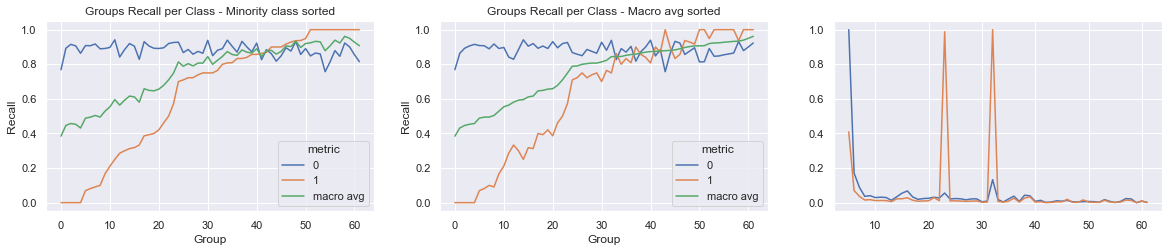

In [26]:
axs = classesGroupRecall(scrs, cls_cnts, ignore_first=5)

---
# Exploratory Data Analysis

### Case Example

In [611]:
CP = ClassificationPipeline(
    train_size=0.79, train_prct=5,
    test_size=0.2, test_prct=None,
    shuffle=True, random_state=0,
)

score, cls_cnt = CP.binary(
    X_filt, Y_filt, model=brfc(), return_cls_cnt=True
)

display(score, cls_cnt)